# Predicting Long-Lived Bugs

# 1. Setup Python Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline 

plt.style.use('default')
sns.set_context("paper")

# 2. Experiment A 

This seventh experiment has used a dataset of bug reports extracted from Eclipse Bugzilla Tracking System. The protocol parameters and values employed in this experiment is shown in the following table:

| Parameter                                    |         Value        |
|--------------------------------------------- |:--------------------:|
| OSS                                          |        eclipse       |
| Total number of bug reports                  |        12.200        |
| Days to resolve range                        |   from 0 to 730      |
| Number of Bug Reports within days to resolve |        10.970        |
| Textual features                             | summary + description|
| Number of terms                              |           200        |
| Fixed threshold                              |             8        |
| Variable threshold                           |          8,64        |
| Method for balancing class                   | downsampling (Manual)|
| Classifiers                                  | knn, svm, rf         |
| Resampling techniques                        | none                 |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 2.1 Describe Bug Reports File

In [2]:
reports_file = 'datasets/20190207_eclipse_bug_reports.csv'

!echo "Header of reports file"
!head -n 2 $reports_file

!echo "\nNumber of reports in the file:"
!wc -l $reports_file


Header of reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,days_to_resolve,severity_category,severity_code
COMMUNITY-455431,2014-12-17,Servers,COMMUNITY,Need SSH access to build.eclipse.org for uwe.stieber@windriver.com,I'm a committer on the tools.cdt.tcf project and got asked to take over some release engineering stuff from my project lead Martin Oberhuber. In order to do this I need to be able to SSH login to build.eclipse.org. Please re-enable the real shell access for my user (Uwe Stieber uwe.stieber@windriver.com).,webmaster,uwe.st,fixed,1,resolved,4,2014-12-17,0,3,2014-12-17,0,normal,2

Number of reports in the file:
  197505 datasets/20190207_eclipse_bug_reports.csv


In [3]:
reports = pd.read_csv(reports_file)
rows_and_cols = reports.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

reports_information = reports.info()
print(reports_information)

reports.head()

There are 12200 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 19 columns):
bug_id                  12200 non-null object
creation_date           12200 non-null object
component_name          12200 non-null object
product_name            12200 non-null object
short_description       12197 non-null object
long_description        12011 non-null object
assignee_name           12200 non-null object
reporter_name           12200 non-null object
resolution_category     12200 non-null object
resolution_code         12200 non-null int64
status_category         12200 non-null object
status_code             12200 non-null int64
update_date             12200 non-null object
quantity_of_votes       12200 non-null int64
quantity_of_comments    12200 non-null int64
resolution_date         12200 non-null object
days_to_resolve         12200 non-null int64
severity_category       12200 non-null object
severity_code           12200 

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,days_to_resolve,severity_category,severity_code
0,COMMUNITY-455431,2014-12-17,Servers,COMMUNITY,Need SSH access to build.eclipse.org for uwe.s...,I'm a committer on the tools.cdt.tcf project a...,webmaster,uwe.st,fixed,1,resolved,4,2014-12-17,0,3,2014-12-17,0,normal,2
1,JDT-31738,2003-02-12,UI,JDT,Weird behavior setting project libraries,Open the properties for a project then Java Bu...,martinae,bogofilter+eclipse.org,fixed,1,resolved,4,2003-02-18,0,4,2003-02-18,6,normal,2
2,ORION-389073,2012-09-07,Git,ORION,Pull gives me an auth fail error without promp...,With the latest changes in git credentials (to...,simon_kaegi,susan,fixed,1,resolved,4,2012-09-12,0,7,2012-09-12,5,major,4
3,JETTY-306226,2010-03-17,client,JETTY,HttpClient should allow changing to the keysto...,(Originally JETTY-1190 @ Codehaus JIRA)\n\nCur...,mgorovoy,mgorovoy,fixed,1,resolved,4,2010-10-13,0,3,2010-05-12,56,normal,2
4,WTP_SOURCE_EDITING-185183,2007-05-02,wst.xsd,WTP_SOURCE_EDITING,Update copyright headers for WSDL and XSD comp...,Update copyright headers for WSDL and XSD comp...,kchong,kchong,fixed,1,closed,6,2007-07-05,0,4,2007-05-02,0,normal,2


## 2.2  Evaluation Metrics

In [4]:
results_file = 'datasets/20190213232312_predicting-metrics-manual.csv'
results = pd.read_csv(results_file)
rows_and_cols = results.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

results_information = results.info()
print(reports_information)

results.head(100)

There are 6 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 24 columns):
dataset               6 non-null object
classifier            6 non-null object
resampling            6 non-null object
balancing             6 non-null object
fixed_threshold       6 non-null int64
variable_threshold    6 non-null int64
train_size            6 non-null int64
train_size_class_0    6 non-null int64
train_size_class_1    6 non-null int64
test_size             6 non-null int64
test_size_class_0     6 non-null int64
test_size_class_1     6 non-null int64
feature               6 non-null object
n_terms               6 non-null int64
tp                    6 non-null int64
fp                    6 non-null int64
tn                    6 non-null int64
fn                    6 non-null int64
acc_class_0           6 non-null float64
acc_class_1           6 non-null float64
balanced_acc          6 non-null float64
precision             6 non-null fl

,dataset,classifier,resampling,balancing,fixed_threshold,variable_threshold,train_size,train_size_class_0,train_size_class_1,test_size,...,tp,fp,tn,fn,acc_class_0,acc_class_1,balanced_acc,precision,recall,fmeasure
0,Eclipse,knn,none,manual,8,8,5354,2677,2677,5354,...,1153,1059,1524,1618,0.521248,0.485041,0.503145,0.521248,0.416095,0.462773
1,Eclipse,svmRadial,none,manual,8,8,5354,2677,2677,5354,...,1464,1178,1213,1499,0.554126,0.447271,0.500699,0.554126,0.494094,0.522391
2,Eclipse,rf,none,manual,8,8,5354,2677,2677,5354,...,1418,1171,1259,1506,0.547702,0.455335,0.501518,0.547702,0.484952,0.514420
3,Eclipse,knn,none,manual,8,64,2730,1365,1365,2728,...,697,637,667,727,0.522489,0.478479,0.500484,0.522489,0.489466,0.505439
4,Eclipse,svmRadial,none,manual,8,64,2730,1365,1365,2728,...,742,596,622,768,0.554559,0.447482,0.501021,0.554559,0.491391,0.521067
5,Eclipse,rf,none,manual,8,64,2730,1365,1365,2728,...,763,632,601,732,0.546953,0.450863,0.498908,0.546953,0.510368,0.528028


# 3. Experiment B

This eighth experiment has used a dataset of bug reports extracted from Eclipse Bugzilla Tracking System. The protocol parameters and values employed in this experiment is shown in the following table:

| Parameter                                          |                      Value                            |
|----------------------------------------------------|:-----------------------------------------------------:|
| OSS                                                |        eclipse                                        |
| Number of bug reports                              |        12.200                                         |
| Days to resolve range                              |   from 0 to 730                                       |
| Number of rug reports within days to resolve range |        10.970                                         |
| Textual features                                   | summary + description                                 |
| Number of terms                                    |           200                                         |
| Fixed Threshold                                    |            64                                         |
| Variable threshold range                           |       from 4 to 64 (step 4)                                |
| Method for balancing class                         | none, downsampling (manual), downsampling (R), smote  |
| Classifiers                                        | knn                                                   |
| Resampling techniques                              | none, bootstrap, cv5x2, repeated cv5x2, loocv, loogcv |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **fixed threshold** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 3.1  Evaluation Metrics

In [5]:
results_file = 'datasets/20190213110244-predicting-metrics.csv'
results = pd.read_csv(results_file)
rows_and_cols = results.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

results_information = results.info()
print(reports_information)

results.sort_values('balanced_acc', ascending=False)

There are 358 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 24 columns):
dataset               358 non-null object
classifier            358 non-null object
resampling            358 non-null object
balancing             358 non-null object
threshold             358 non-null int64
fixed_threshold       358 non-null int64
train_size            358 non-null int64
train_size_class_0    358 non-null int64
train_size_class_1    358 non-null int64
test_size             358 non-null int64
test_size_class_0     358 non-null int64
test_size_class_1     358 non-null int64
feature               358 non-null object
n_term                358 non-null int64
tp                    358 non-null int64
fp                    358 non-null int64
tn                    358 non-null int64
fn                    358 non-null int64
acc_class_0           358 non-null float64
acc_class_1           358 non-null float64
balanced_acc          358 non-

,dataset,classifier,resampling,balancing,threshold,fixed_threshold,train_size,train_size_class_0,train_size_class_1,test_size,...,tp,fp,tn,fn,acc_class_0,acc_class_1,balanced_acc,precision,recall,fmeasure
319,Eclipse,knn,none,unbalanced,64,64,8211,6164,2047,2736,...,1743,579,311,103,0.750646,0.751208,0.750927,0.750646,0.944204,0.836372
55,Eclipse,knn,boot,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
247,Eclipse,knn,LOOCV,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
183,Eclipse,knn,LGOCV,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
119,Eclipse,knn,cv,unbalanced,56,64,8071,6024,2047,2689,...,1783,603,224,79,0.747276,0.739274,0.743275,0.747276,0.957573,0.839454
63,Eclipse,knn,boot,unbalanced,64,64,8211,6164,2047,2736,...,1840,604,214,78,0.752864,0.732877,0.742870,0.752864,0.959333,0.843650
191,Eclipse,knn,LGOCV,unbalanced,64,64,8211,6164,2047,2736,...,1840,604,214,78,0.752864,0.732877,0.742870,0.752864,0.959333,0.843650
127,Eclipse,knn,cv,unbalanced,64,64,8211,6164,2047,2736,...,1839,603,215,79,0.753071,0.731293,0.742182,0.753071,0.958811,0.843578
255,Eclipse,knn,LOOCV,unbalanced,64,64,8211,6164,2047,2736,...,1841,603,213,79,0.753273,0.729452,0.741363,0.753273,0.958854,0.843721
311,Eclipse,knn,none,unbalanced,56,64,8071,6024,2047,2689,...,1682,561,325,121,0.749889,0.728700,0.739294,0.749889,0.932890,0.831438


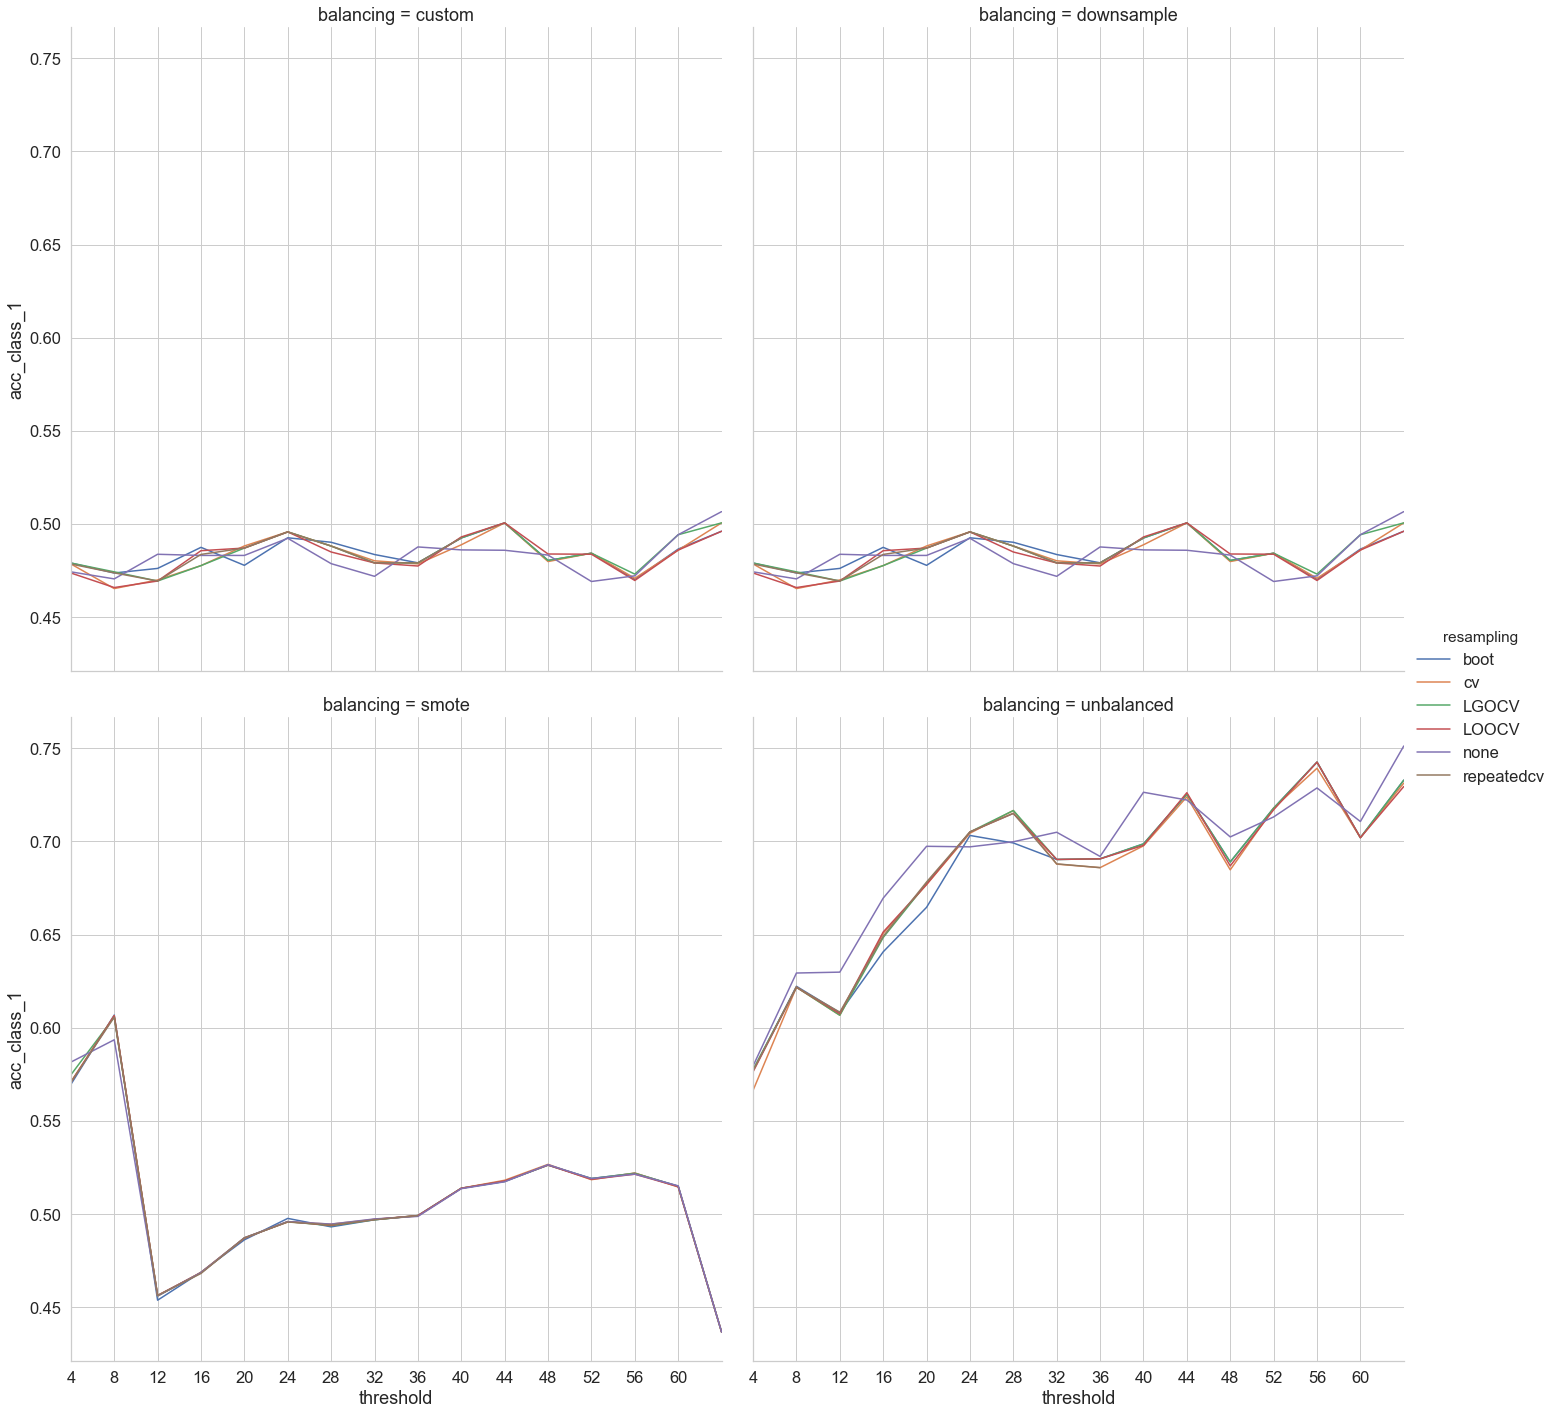

In [19]:
sns.color_palette("bright")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
data=results[['threshold', 'resampling', 'balancing', 'balanced_acc', 'acc_class_1', 'test_size_class_1']]
g = sns.FacetGrid(data=data, hue="resampling", col="balancing", col_wrap=2, height=10)
g = g.map(sns.lineplot, 'threshold', 'acc_class_1')
g.set(xlim=(4, 64))
g.set(xticks=range(4, 64, 4))
#g.set(ylim=(0.4, 0.8))
g.add_legend()